# Week 05 Return Rate Prediction Model

For stock price prediction, our real prediction goal is daily return. The reasons are as follows:
1. The rate of return is stable: Fluctuations in stock prices may be affected by a variety of factors, including market noise, emotions, and macroeconomics.
Data etc. This can make price predictions relatively difficult. In contrast, yields offset these effects somewhat, so that to some extent
more stable.
2. Relatively stable return distribution: The distribution of return is relatively stable and more consistent with statistical assumptions, making predictions based on statistical models more reliable.
Depend on. This also helps deep learning models learn patterns better.
3. Avoid data magnitude differences: Stock prices usually have a large value range, while return rates are relatively small. Predicting returns can
Avoiding order-of-magnitude differences in input data helps train stable models.
4. Short-term forecasts are relatively more stable: Price changes in the short term are usually affected by fewer non-fundamental factors and are relatively easier to predict. pre
The measured rate of return may have more reference value in the short term.
Daily return can be directly calculated from stock price data and used as our target.


Refer to the paper Prediction of stock return by LSTM neural network and use these stock data to train a daily
return prediction model.
When building the model, please refer to Machine Learning Models Predicting Returns: Why Most Popular
Performance Metrics Are Misleading and Proposal for an Efficient Metric, use more investment income-based
Algorithms evaluate model capabilities.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from keras import optimizers

/var/folders/hl/6492kk1939x_mv_8fr9qfz_40000gn/T/ipykernel_46629/3371754694.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data Extraction

In [75]:
row_data_path = '../../data/row/'
stickers = ['AAPL', 'INTC', 'AMD', 'TSM', 'QCOM', 'AVGO', 'SNPS', 'CRUS',
            'META', 'AMZN', 'MSFT', 'GOOGL', 'MU', 'MRVL', 'NXPI', 'STM', 'HPQ', 'IBM', 'CSCO']

data_dict = {}


# Calculate Daily Return

In [100]:

for sticker in stickers:
    data = pd.read_csv(row_data_path + sticker + '_5_years_daily_data.csv',
                       index_col='date', parse_dates=True)
    data['daily_return'] = data['5. adjusted close'].pct_change()
    data_dict[sticker] = data

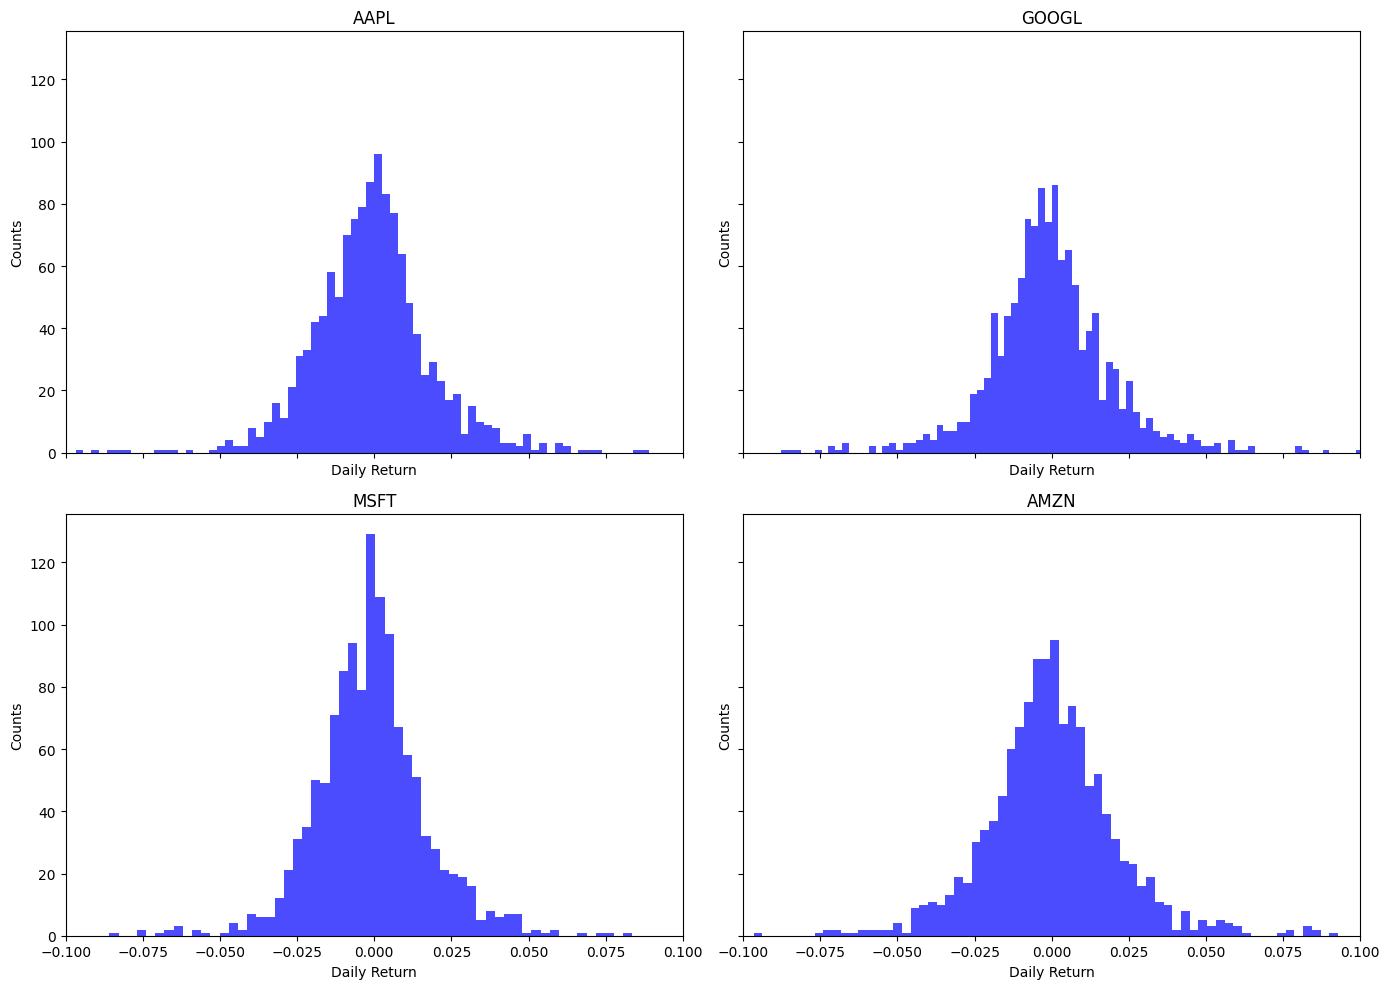

In [101]:
# We'll use 100 bins for each histogram to get a similar look and feel as the provided screenshot.

# Define the figure for plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten the array for easy iteration

# List of companies and their data
company_names = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
companies_data = [data_dict[name] for name in company_names]

# Plot histograms of daily returns for each company with adjusted parameters
for ax, data, name in zip(axs, companies_data, company_names):
    # Plot the histogram with 100 bins and density=False to show counts
    ax.hist(data['daily_return'].dropna(), bins=100,
            color='blue', alpha=0.7, density=False)
    ax.set_title(f'{name}')
    ax.set_xlabel('Daily Return')
    ax.set_ylabel('Counts')
    # Set the limits for x-axis to normalize across all histograms
    ax.set_xlim(-0.1, 0.1)

plt.tight_layout()
plt.show()

In [102]:
data_dict.values()

dict_values([            1. open   2. high   3. low  4. close  5. adjusted close  \
date                                                                  
2024-03-19   174.34  176.6050  173.030    176.08         176.080000   
2024-03-18   175.57  177.7100  173.520    173.72         173.720000   
2024-03-15   171.17  172.6200  170.285    172.62         172.620000   
2024-03-14   172.91  174.3078  172.050    173.00         173.000000   
2024-03-13   172.77  173.1850  170.760    171.13         171.130000   
...             ...       ...      ...       ...                ...   
2019-03-26   191.66  192.8800  184.580    186.79          44.954228   
2019-03-25   191.51  191.9800  186.600    188.74          45.423529   
2019-03-22   195.34  197.6900  190.780    191.05          45.979470   
2019-03-21   190.02  196.3300  189.810    195.09          46.951765   
2019-03-20   186.23  189.4900  184.730    188.16          45.283942   

              6. volume  7. dividend amount  8. split coefficie

In [103]:
# We will ignore the index to allow for a continuous index in the new DataFrame.
combined_data = pd.concat(
    [value for value in data_dict.values()], ignore_index=True)

In [104]:
combined_data.dropna(inplace=True)
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23902 entries, 1 to 23920
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1. open               23902 non-null  float64
 1   2. high               23902 non-null  float64
 2   3. low                23902 non-null  float64
 3   4. close              23902 non-null  float64
 4   5. adjusted close     23902 non-null  float64
 5   6. volume             23902 non-null  float64
 6   7. dividend amount    23902 non-null  float64
 7   8. split coefficient  23902 non-null  float64
 8   daily_return          23902 non-null  float64
dtypes: float64(9)
memory usage: 1.8 MB


In [105]:
combined_data

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,daily_return
1,175.57,177.7100,173.520,173.72,173.720000,75604184.0,0.0,1.0,-0.013403
2,171.17,172.6200,170.285,172.62,172.620000,121752699.0,0.0,1.0,-0.006332
3,172.91,174.3078,172.050,173.00,173.000000,72571635.0,0.0,1.0,0.002201
4,172.77,173.1850,170.760,171.13,171.130000,51948951.0,0.0,1.0,-0.010809
5,173.15,174.0300,171.010,173.23,173.230000,59544927.0,0.0,1.0,0.012271
...,...,...,...,...,...,...,...,...,...
23916,53.19,53.4900,53.000,53.23,45.769343,17742681.0,0.0,1.0,0.001694
23917,52.70,52.9300,52.250,52.73,45.339422,18774884.0,0.0,1.0,-0.009393
23918,53.91,54.1400,52.700,52.74,45.348021,23938450.0,0.0,1.0,0.000190
23919,53.08,54.2300,53.040,53.94,46.379830,20082716.0,0.0,1.0,0.022753


# LSTM for Daily Return Prediction

In [106]:
# Encode the 'Stock' variable using one-hot encoding
stock_dummies = pd.get_dummies(combined_data, drop_first=True)

# Create an instance of StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(
    combined_data[['1. open', '2. high', '3. low', '5. adjusted close', '6. volume']])

# Combine the scaled features with stock dummy variables
scaled_features_with_stock = np.hstack((scaled_features, stock_dummies.values))

In [107]:
# Use scaled_features_with_stock as input for X in the next steps
# Define the size of the time window
time_steps = 20

# Construct data window function


def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


# Create dataset
X, y = create_dataset(scaled_features_with_stock,
                      combined_data['daily_return'], time_steps)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,
          input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))

# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(learning_rate=0.01))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=20, batch_size=16,
                    validation_split=0.15, verbose=1)

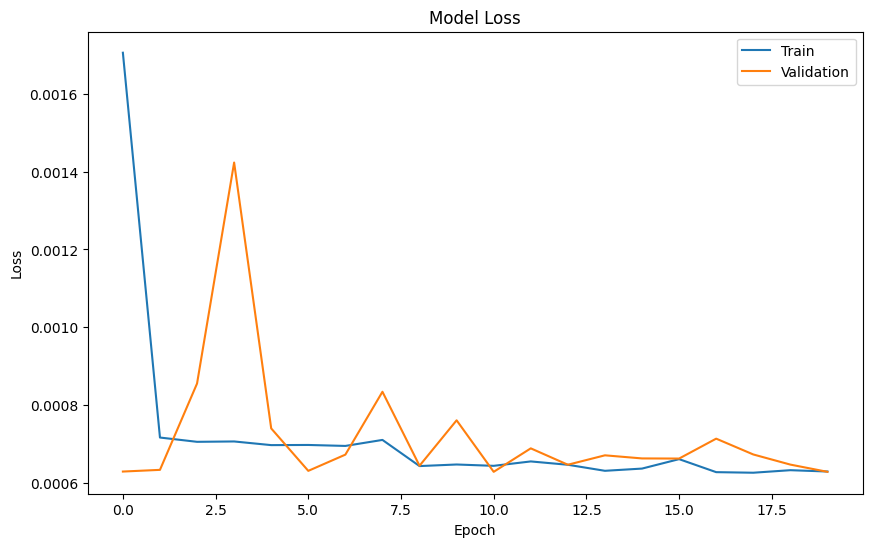

In [121]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [122]:
# Predicting the test set results
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error: 0.000635657705094636


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


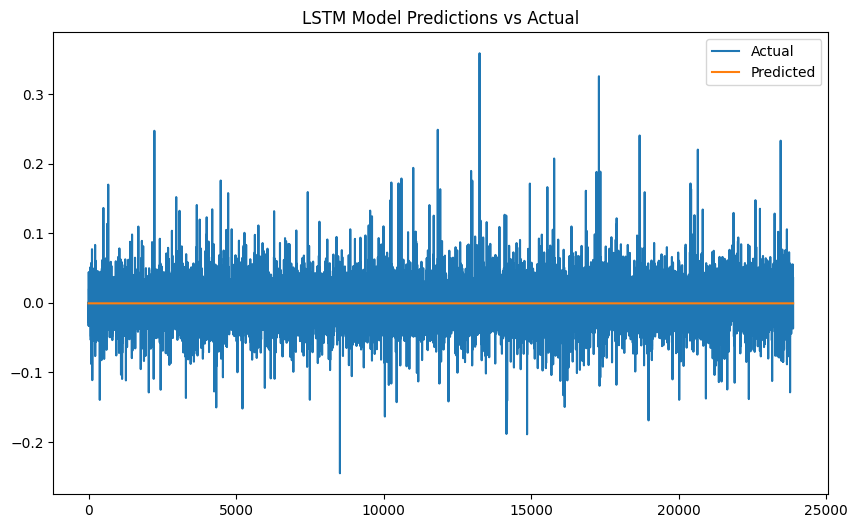

In [123]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Plotting predictions for a quick view
plt.figure(figsize=(10, 6))
plt.plot(np.append(y_train, y_test), label='Actual')
plt.plot(np.append(train_predict, test_predict), label='Predicted')
plt.legend()
plt.title('LSTM Model Predictions vs Actual')
plt.show()

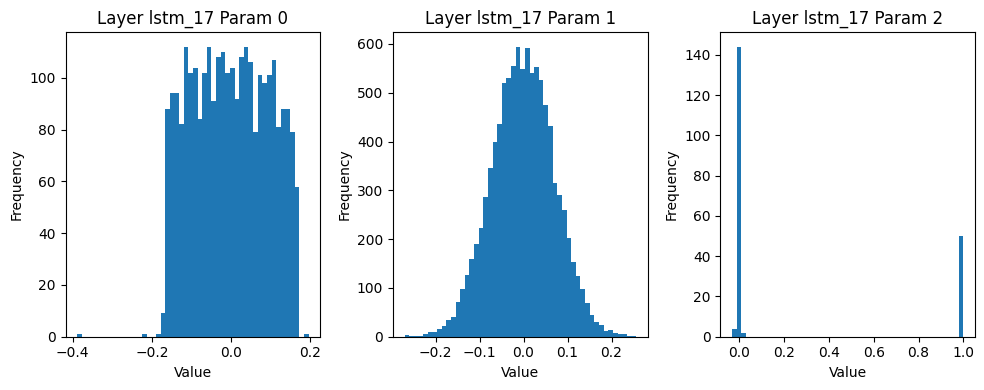

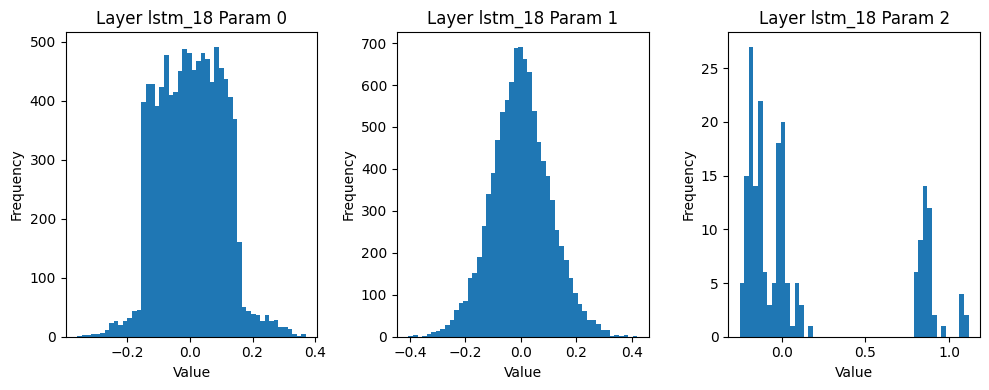

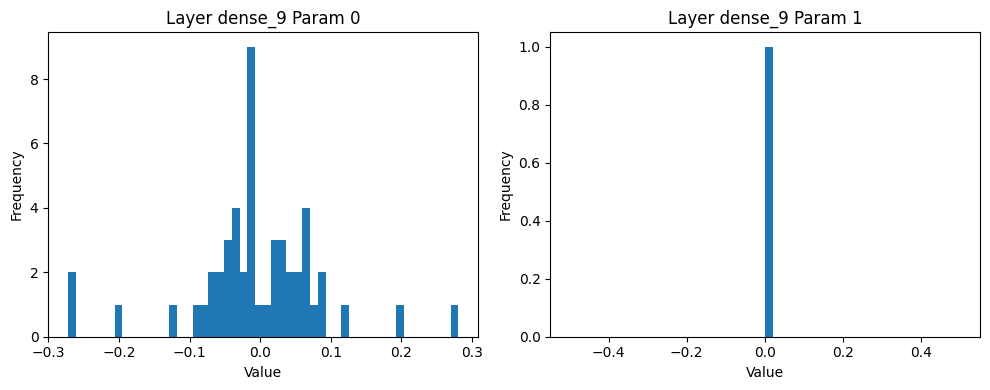

In [112]:
# extract the model's layers
layers = model.layers

# loop through the layers
for layer in layers:
    weights = layer.get_weights() # get the weights
    if len(weights) > 0:
        # plot the weights
        plt.figure(figsize=(10, 4))
        for i, weight in enumerate(weights):
            plt.subplot(1, len(weights), i + 1)
            plt.hist(weight.flatten(), bins=50)
            plt.title(f'Layer {layer.name} Param {i}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

# Model Evaluation

In [124]:
def calculate_roi(data, initial_investment=1):
    """
    Calculate the Return on Investment (ROI) for a given data set.

    Parameters:
    data (pd.Series): Time series data of returns.
    initial_investment (float): Initial amount invested (default is 1).

    Returns:
    float: The ROI.
    """
    # calculate the cumulative return
    cumulative_return = (1 + data).cumprod().iloc[-1] - 1
    # calculate the ROI
    roi = initial_investment * cumulative_return
    return roi


# calculate the ROI for the buy and hold strategy
roi_bh = calculate_roi(combined_data['daily_return'])

# convert the predicted returns to a series
predicted_returns_series = pd.Series(y_pred.flatten())

# calculate the ROI for the algorithm
roi_algo = calculate_roi(predicted_returns_series)

print("ROI for Algorithm:", roi_algo)
print("ROI for Buy & Hold Strategy:", roi_bh)

ROI for Algorithm: -0.9941815906204283
ROI for Buy & Hold Strategy: -0.9999999950334144


In [125]:
# calculate the D-Return Ratio
d_return = 1 + (roi_algo - roi_bh) / abs(roi_bh)

print("D-return Ratio:", d_return)

D-return Ratio: 1.0058184044418836


In [126]:
def calculate_var(returns, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) for a given returns series.

    Parameters:
    returns (np.array): Array of returns.
    confidence_level (float): The confidence level (default is 0.95).

    Returns:
    float: The VaR value.
    """
    mean = np.mean(returns)
    std_dev = np.std(returns)
    var = norm.ppf(1 - confidence_level, mean, std_dev)
    return var


# calculate the VaR for the buy and hold strategy
var_bh = calculate_var(combined_data['daily_return'])

# calculate the VaR for the algorithm strategy
predicted_returns_series = pd.Series(y_pred.flatten())

# calculate the VaR for the algorithm strategy
var_algo = calculate_var(predicted_returns_series)

print("VaR for Algorithm Strategy:", var_algo)
print("VaR for Buy & Hold Strategy:", var_bh)

VaR for Algorithm Strategy: -0.0007180525035206402
VaR for Buy & Hold Strategy: -0.0413790290499459


In [127]:
# calculate the D-var ratio
d_var = var_bh / var_algo
# calculate the D-ratio
d_ratio = d_return * d_var

In [128]:
# annualized return
annualized_return = (np.prod(1 + y_pred) - 1) * (365 / len(y_pred))

# sharpe ratio
risk_free_rate = 0.01  # 假设无风险利率
excess_returns = y_pred - (risk_free_rate / 252)
sharpe_ratio = (np.mean(excess_returns) /
                np.std(excess_returns)) * np.sqrt(252)

# maximum drawdown
cumulative_returns = (1 + y_pred).cumprod()
running_max = np.maximum.accumulate(cumulative_returns)
drawdown = (running_max - cumulative_returns) / running_max
max_drawdown = np.max(drawdown)

In [129]:
# calmar ratio
calmar_ratio = annualized_return / max_drawdown

In [130]:
daily_returns = combined_data['daily_return']

# calculate downside deviation
negative_returns = daily_returns[daily_returns < risk_free_rate]
downside_std = np.std(negative_returns) * np.sqrt(252)

# calculate Sortino ratio
sortino_ratio = (annualized_return - risk_free_rate) / downside_std

In [131]:
print("Annualized Return:", annualized_return)
print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("D-return Ratio:", d_return)
print("D-VaR Ratio:", d_var)
print("D-ratio:", d_ratio)
print("Calmar_ratio", calmar_ratio)
print("Sortino Ratio:", sortino_ratio)

Annualized Return: -0.05064567767989621
Sharpe Ratio: -103267872.47818163
Maximum Drawdown: 0.9941774
D-return Ratio: 1.0058184044418836
D-VaR Ratio: 57.62674574221643
D-ratio: 57.96204145561424
Calmar_ratio -0.050942294227972355
Sortino Ratio: -0.22247037980918452
